In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
!pip install -U torch torchvision transformers scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from transformers import CLIPModel, CLIPProcessor


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/chest_xray/train"
TEST_DIR  = "/content/drive/MyDrive/chest_xray/test"


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
train_dataset = ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset  = ImageFolder(TEST_DIR, transform=train_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)

print(train_dataset.classes)


['NORMAL', 'PNEUMONIA']


In [ ]:
model_id = "openai/clip-vit-base-patch16"

clip_model = CLIPModel.from_pretrained(model_id).to(device)
processor  = CLIPProcessor.from_pretrained(model_id)


In [ ]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.classifier = nn.Linear(
            clip_model.config.projection_dim, 2
        )

    def forward(self, pixel_values):
        image_features = self.clip.get_image_features(
            pixel_values=pixel_values
        )
        logits = self.classifier(image_features)
        return logits


In [ ]:
model = CLIPClassifier(clip_model).to(device)


In [ ]:
for param in model.clip.parameters():
    param.requires_grad = False


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.classifier.parameters(), lr=1e-3)


In [ ]:
print(images.min().item(), images.max().item())


0.0 1.0


In [ ]:
EPOCHS = 5
model.train()

for epoch in range(EPOCHS):
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        inputs = processor(
            images=list(images),
            return_tensors="pt",
            do_rescale=False
        ).to(device)

        logits = model(inputs.pixel_values)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")


Epoch [1/5] - Loss: 0.3609
Epoch [2/5] - Loss: 0.2246
Epoch [3/5] - Loss: 0.1861
Epoch [4/5] - Loss: 0.1662
Epoch [5/5] - Loss: 0.1521


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
model.eval()


CLIPClassifier(
  (clip): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=True)
 

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        inputs = processor(
            images=list(images),
            return_tensors="pt",
            do_rescale=False
        ).to(device)

        logits = model(inputs.pixel_values)
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [ ]:
acc = accuracy_score(y_true, y_pred)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary"
)

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.7356
Precision : 0.7103
Recall    : 0.9744
F1-score  : 0.8216


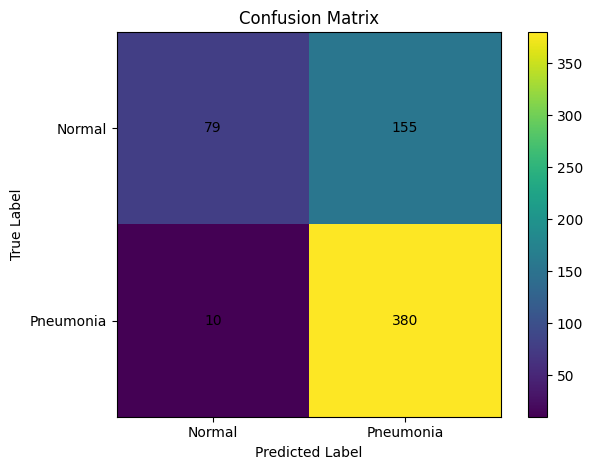

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

classes = ["Normal", "Pneumonia"]
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1_score  = f1_score(y_true, y_pred)


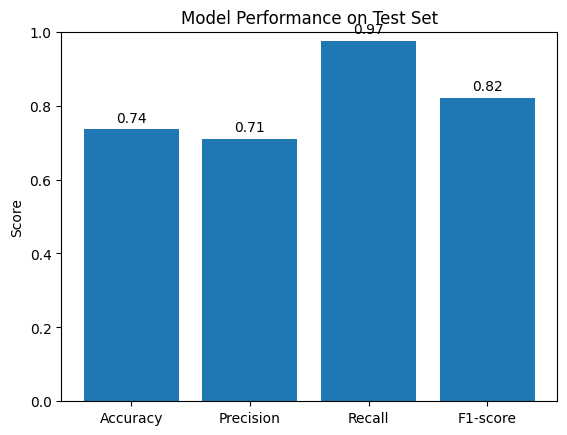

In [ ]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [accuracy, precision, recall, f1_score]

plt.figure()
plt.bar(metrics, values)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance on Test Set")

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")

plt.show()


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/experiments/medclip_pneumonia/checkpoints"


In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/experiments/medclip_pneumonia/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)


In [ ]:
checkpoint = {
    "epoch": 5,
    "model_state_dict": clip_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "model_name": "openai/clip-vit-base-patch16",
    "task": "Chest X-ray Pneumonia Classification"
}


In [ ]:
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_1.pth")
torch.save(checkpoint, checkpoint_path)

print(f"✅ Checkpoint 1 saved at:\n{checkpoint_path}")


✅ Checkpoint 1 saved at:
/content/drive/MyDrive/experiments/medclip_pneumonia/checkpoints/checkpoint_1.pth


In [ ]:
print("Files in checkpoint directory:")
print(os.listdir(checkpoint_dir))


Files in checkpoint directory:
['checkpoint_1.pth']


In [3]:
import os

base_path = "/content/drive/MyDrive/chest-xray-medclip"

folders = [
    "experiments/exp1_zero_shot_evaluation/figures",
    "experiments/exp2_finetuning/figures",
    "checkpoints"
]

for f in folders:
    os.makedirs(os.path.join(base_path, f), exist_ok=True)

print("Project structure created.")


Project structure created.


In [4]:
import json

results = {
    "accuracy": 0.7356,
    "precision": 0.7103,
    "recall": 0.9744,
    "f1_score": 0.8216
}

with open(f"{base_path}/experiments/exp2_finetuning/results.json", "w") as f:
    json.dump(results, f, indent=4)


In [7]:
with open(f"{base_path}/.gitignore", "w") as f:
    f.write("""
checkpoints/
*.pth
*.pt
__pycache__/
.ipynb_checkpoints/
""")
